<a href="https://colab.research.google.com/github/isavida/football-task/blob/team-classification/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install ultralytics -q
!pip install easyocr -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.3/719.3 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 908.3/908.3 kB 25.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.2/307.2 kB 19.2 MB/s eta 0:00:00


In [ ]:
import colorsys
import copy
import cv2
import easyocr
import imutils
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

from google.colab.patches import cv2_imshow
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans
from ultralytics import YOLO

#Setup

In [ ]:
def git_setup(token):
  os.system(f"git config --global user.email 'isabel.vidaurre@hotmail.com'")
  os.system(f"git config --global user.name 'isavida'")
  os.system(f"git clone https://{token}@github.com/isavida/football-task.git")
  os.chdir("football-task")

In [ ]:
git_setup('123123')

# Introduction
The task consists of taking as input a video footage and output:


*   A JSONL file that contains a row for each 5th frame with the number of players from home-team and away-team, numbers of referees and position of the ball.
*   A video with the team players with the bounding boxes of detections
classified according to their team and the annotation of the ball when detected


It is decided to do the player detection task first, as the data for the jsonl file can be obtained from these detections.



#Players detection

In [ ]:
video_capture = "clip_3"


WARNING ⚠️ inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

Results saved to runs/detect/clip_3_result


##Team classification
To correctly classify each team, the team colors should be finded.

As a first approach, is proposed to use the **k-means clustering algorithm** to detect the colors of the jerseys from the bounding boxes of the players, processing the image by removing the green background to have the maximum percentage of relevant information possible.

This approach does not provide the expected results and also does not provide the information of which equipment belongs to the home team and which to the visiting team, so it was decided to obtain all this information from the **scoreboard**.

*Although this notebook does not keep all the code that has been tested for readability, it can be consulted in previous commits.*

### Getting info from scoreboard


Considering that in the task we should distinguish between the home and the away team, another approach could be to identify the colors and the affiliation to the home or the away team by looking at the scoreboard.

In [77]:
def get_static_pixels_from_video(filepath, n_samples=10, std_ratio = 0.04, crop_x_ratio = 0.4, crop_y_ratio = 0.2):
    ''' Crop parameters just accelerates the workflow since we know that the
    scoreboard is located at the upper-left corner. The reader can test
    this function with both crop ratios = 1, which takes around 30 secs using CPU'''
    cap = cv2.VideoCapture(filepath)

    # Randomly select n sample frames
    sample_frames_index = [np.random.randint(0, cap.get(cv2.CAP_PROP_FRAME_COUNT)) for i in range(n_samples)]

    # Store selected frames in an array
    sample_frames = []
    for sfi in sample_frames_index:
        cap.set(cv2.CAP_PROP_POS_FRAMES, sfi)
        _, frame = cap.read()
        if frame is not None:
            sample_frames.append(frame[0:int(crop_y_ratio * frame.shape[0]),
                                0:int(crop_x_ratio * frame.shape[1])])

    # std will help to check static pixels
    # median obtains a precise scoreboard in case it's damaged on any frame
    std_frames = np.std(sample_frames, axis=0).astype(dtype=np.uint8)
    median_frames = np.median(sample_frames, axis=0).astype(dtype=np.uint8)

    # get mean over color channels
    std_frame_mean = np.mean(std_frames/255, axis=2)
    std_frame_mean_3D = np.repeat(std_frame_mean[:,:,np.newaxis], 3, axis=2)

    # filter static pixels
    background = np.where(std_frame_mean_3D < std_ratio, median_frames, 0)

    return background

def xywh_from_points_with_scale(points_2d, scale=1.2):
    ''' Compute center_x, center_y, width and weight given N 2d points '''

    x_min = np.min(points_2d[:,0], axis=0)
    x_max = np.max(points_2d[:,0], axis=0)
    y_min = np.min(points_2d[:,1], axis=0)
    y_max = np.max(points_2d[:,1], axis=0)

    return [(x_max+x_min)/2,
            (y_max+y_min)/2,
            (x_max-x_min) * scale,
            (y_max-y_min) * scale]

def crop_image_given_xywh(image, xywh):
    x_min = int(xywh[0] - xywh[2]/2)
    x_max = int(xywh[0] + xywh[2]/2)
    y_min = int(xywh[1] - xywh[3]/2)
    y_max = int(xywh[1] + xywh[3]/2)

    return image[y_min:y_max, x_min:x_max]

def detect_team_scoreboard_and_crop_image(background):
    # read image
    img = copy.deepcopy(background)

    # instance text detector
    reader = easyocr.Reader(['en'], gpu=False)

    # detect text on image
    text_ = reader.readtext(img)

    threshold = 0.25
    initials = []

    # draw bbox and text of team initials
    for t_, t in enumerate(text_):
        bbox, text, score = t

        if score > threshold and len(text) == 3:
            #cv2.rectangle(img, bbox[0], bbox[2], (0, 255, 0), 5)
            #cv2.putText(img, text, bbox[0], cv2.FONT_HERSHEY_COMPLEX, 0.65, (255, 0, 0), 2)

            initials.append(bbox)

    initials_np = np.array(initials)
    initials_np = initials_np.reshape(initials_np.shape[0] * initials_np.shape[1], initials_np.shape[2])

    xywh = xywh_from_points_with_scale(initials_np)
    crop_img = crop_image_given_xywh(img, xywh)

    return crop_img


In [78]:
def split_scoreboard_per_team(scoreboard):
    img_width = scoreboard.shape[1]
    return scoreboard[:,:img_width//2,:], scoreboard[:,img_width//2:,:]

In [79]:
def quantize_img(img, K=32):
    ''' This function quantize the input image by using k-means algorithm,
        dividing the input image in the K most-predominant colors'''
    # Preprocess input img
    Z = img.reshape((-1,3))
    Z = np.float32(Z)

    # Specify stopping criteria, max_iters and desired-accuracy
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    #(samples,nclusters,None,criteria,attempts,flags)
    ret,label,center=cv2.kmeans(Z,K,None,criteria,10,cv2.KMEANS_RANDOM_CENTERS)

    # Postprocess back img to original structure
    center = np.uint8(center)
    res = center[label.flatten()]
    quantized_img = res.reshape((img.shape))

    return quantized_img

In [80]:
def display_dominant_colors(dominant_colors):
    # Create a blank white image
    bar = np.zeros((50, 300, 3), dtype=np.uint8)
    startX = 0

    # For each dominant color, draw a rectangle on the blank image
    for color in dominant_colors:
        endX = startX + (300 // len(dominant_colors))
        cv2.rectangle(bar, (int(startX), 0), (int(endX), 50), color.astype(int).tolist(), -1)
        startX = endX

    # Display the image
    cv2_imshow(bar)

In [81]:
def get_color_frequencies(img):
    ''' Get color frequencies and return pd dataframe '''

    img_nx3 = np.float32(img.reshape(-1, 3))

    unique_pixels, counts = np.unique(img_nx3, axis=0, return_counts=True)

    color_dict = {'color': [tuple(color) for color in unique_pixels],
                  'frequency': counts}

    return pd.DataFrame(color_dict)

def get_most_distinctive_color(color_freq_home, color_freq_away, ratio=10):
  df_merged = pd.merge(color_freq_home, color_freq_away, on='color', suffixes=('_df1', '_df2'), how='outer')

  # Compute difference between frequencies in both dataframes
  df_merged['frequency_difference'] = abs(df_merged['frequency_df1']/df_merged['frequency_df2'])

  # If the frequencies are bigger than ratio or lower than 1/ratio or Nan(meaning that the color is in one side, but not in the other) is considered a difference to consider
  outstanding_differences = df_merged[
    (df_merged['frequency_difference'] > ratio) |
    (df_merged['frequency_difference'] < 1/ratio) |
    (df_merged['frequency_difference'].isna())
  ]

  # Retrieve the rows with the most frequency for each df from these differences
  max_frequency_df1 = outstanding_differences.loc[outstanding_differences['frequency_df1'].idxmax()]
  max_frequency_df2 = outstanding_differences.loc[outstanding_differences['frequency_df2'].idxmax()]

  return max_frequency_df1['color'], max_frequency_df2['color']


In [82]:
def get_color_per_team_from_video(filepath, kmeans_nclusters=32, color_freq_ratio=10):
    ''' Workflow which takes a video as input and return the color assigned to home and away team '''

    # Extract scoreboard from video
    background = get_static_pixels_from_video(filepath)
    scoreboard = detect_team_scoreboard_and_crop_image(background)

    # Quantize scoreboard and split in home-away teams
    quantized_scoreboard = quantize_img(scoreboard, kmeans_nclusters)
    quantized_home_scoreboard, quantized_away_scoreboard = split_scoreboard_per_team(quantized_scoreboard)

    # Get color frequency per team
    color_frequencies_home_scoreboard = get_color_frequencies(quantized_home_scoreboard)
    color_frequencies_away_scoreboard = get_color_frequencies(quantized_away_scoreboard)

    # Get the most used color in a team that is mostly never used in the other team
    return get_most_distinctive_color(color_frequencies_home_scoreboard, color_frequencies_away_scoreboard, color_freq_ratio)

(34.0, 30.0, 172.0) (126.0, 58.0, 41.0)


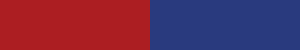

In [83]:
filepath = f"data/{video_capture}.mp4"
home_color, away_color = get_color_per_team_from_video(filepath)

print(home_color, away_color)
display_dominant_colors([np.array(home_color), np.array(away_color)])

###Players classification
Once we have obtained from the scoreboard the color of the home team and the color of the away team, we use the OpenCV *cv2.inRange* method to detect the colors in the jerseys that are in a range around the colors of the teams.


This process is performed in the HSV color space, as it allows a better color separation and to take into account aspects such as brightness and saturation, which are important for color detection.

In [ ]:
def get_color_boundaries(color):
  h, s, v= colorsys.rgb_to_hsv(color[2], color[1], color[0]) #obtain hsv values from color
  # translate into opencv space
  h = int(180*h)
  s = int(255*s)
  v = int(v)

  low_h=h-20
  top_h=h+20
  additionalMask = False

  # h coordinates are circular, we have to consider this for red color
  if low_h < 0:
    new_low_h = low_h + 180
    new_top_h = 180
    low_h = 0
    additionalMask = True
  elif top_h>180:
    new_top_h = top_h - 180
    new_low_h = 0
    top_h = 180
    additionalMask = True

  lower_bound = np.array([low_h, np.clip(s-90,0,255), np.clip(v-90,0,255)])
  upper_bound = np.array([top_h, np.clip(s+90,0,255), np.clip(v+90,0,255)])

  if additionalMask:
    additional_lower_bound = np.array([new_low_h, np.clip(s-90,0,255), np.clip(v-90,0,255)])
    additional_upper_bound = np.array([new_top_h, np.clip(s+90,0,255), np.clip(v+90,0,255)])
    return lower_bound, upper_bound, additional_lower_bound, additional_upper_bound

  return lower_bound, upper_bound

def get_mask(player_hsv, boundaries):

  mask = cv2.inRange(player_hsv, boundaries[0], boundaries[1])

  if len(boundaries)==4:
    mask1 = cv2.inRange(player_hsv, boundaries[2], boundaries[3])
    mask = mask + mask1

  return mask

def team_classification(player, ht_color_boundaries, at_color_boundaries, debug=False):

  player_hsv = cv2.cvtColor(player,cv2.COLOR_BGR2HSV)

  output_ht = cv2.bitwise_and(player_hsv,player_hsv,mask=get_mask(player_hsv, ht_color_boundaries))
  ht_count = np.count_nonzero(output_ht)

  output_at = cv2.bitwise_and(player_hsv,player_hsv,mask=get_mask(player_hsv, at_color_boundaries))
  at_count = np.count_nonzero(output_at)

  tot_count = np.count_nonzero(player_hsv)

  ht_percentage = ht_count/tot_count
  at_percentage = at_count/tot_count

  if debug:
    cv2_imshow(player_hsv)

    print('Percentage of pixels home team : ', ht_percentage)
    cv2_imshow(output_ht)

    print('Percentage of pixels away team  : ', at_percentage)
    cv2_imshow(output_at)


  if ht_percentage>0.01 and ht_percentage>at_percentage:
    return 'Home', home_color

  elif at_percentage>0.01 and at_percentage>ht_percentage:
    return 'Away', away_color

  else:
    return 'Not sure', (0.0, 0.0, 0.0)


In [ ]:
def get_upper_left_corner_location(coordinates):
  ''' YOLO x-y coordinates refers to the center of the detected image.
  This functions gets the upper-left corner as a util in order to create the mask of the bounding boxes '''
  center_x, center_y, w, h = coordinates
  x= int(center_x - w/2)
  y= int(center_y - h/2)

  return x, y


In [ ]:
def get_processed_img(orig_img, bounding_boxes, ht_boundaries, at_boundaries):
  ## remove green
  hsv = cv2.cvtColor(orig_img, cv2.COLOR_BGR2HSV)
  green_mask = cv2.inRange(hsv, (35, 35, 35), (70, 255,255))
  inverted_green_mask= cv2.bitwise_not(green_mask)
  processed_img = cv2.bitwise_and(orig_img,orig_img, mask=inverted_green_mask)
  final_image = np.copy(orig_img)
  for box in bounding_boxes:
    if box.cls==0: #cls 0 corresponds to person
      x, y, w, h=map(int, box.xywh.tolist()[0])
      x,y = get_upper_left_corner_location([int(x),y,w,h])

      player_torso = processed_img[y:y+(h//2),x:x+w] #crop image to only have the torso
      team_text, color_float = team_classification(player_torso, ht_boundaries, at_boundaries, debug=False)
      final_image = cv2.rectangle (final_image, (x, y), (x+w,y+h), (int(color_float[0]), int(color_float[1]), int(color_float[2])), 2)
      final_image = cv2.putText(final_image, team_text,(x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.50, (0, 0, 0), 2)

  return final_image

In [75]:
model = YOLO('yolov8n.pt')

input_video = cv2.VideoCapture(f'data/{video_capture}.mp4')
width = int(input_video.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(input_video.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = int(input_video.get(cv2.CAP_PROP_FPS))

if not os.path.exists('output'):
  os.makedirs('output')

#create video output with same properties as input
output_video = cv2.VideoWriter(f'output/{video_capture}.mp4', cv2.VideoWriter_fourcc(*'mp4v'), fps, (width, height))

ht_boundaries = get_color_boundaries(home_color)
at_boundaries = get_color_boundaries(away_color)

while input_video.isOpened():
  success, frame = input_video.read()
  if success:
    results = model.track(frame, persist = True, verbose=False) # predict each frame with YOLO model
    for i, r in enumerate(results):
      new_frame = get_processed_img(r.orig_img, r.boxes, ht_boundaries, at_boundaries)
      output_video.write(new_frame)
  else:
    break

input_video.release()
output_video.release()


'for i, r in enumerate(results):\n  print(i)\n  new_frame = get_processed_img(r.orig_img, r.boxes, ht_boundaries, at_boundaries)\n  output_video.write(new_frame)\noutput_video.release()'